In [1]:
%matplotlib inline


# Classification of text documents using sparse features


This is an example showing how scikit-learn can be used to classify documents
by topics using a bag-of-words approach. This example uses a scipy.sparse
matrix to store the features and demonstrates various classifiers that can
efficiently handle sparse matrices.

The dataset used in this example is the 20 newsgroups dataset. It will be
automatically downloaded, then cached.

The bar plot indicates the accuracy, training time (normalized) and test time
(normalized) of each classifier.



In [5]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Olivier Grisel <olivier.grisel@ensta.org>
#         Mathieu Blondel <mathieu@mblondel.org>
#         Lars Buitinck
# License: BSD 3 clause

from __future__ import print_function

import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics




Load some categories from the training set


In [28]:

categories = None

remove = ()

print("Loading 20 newsgroups dataset for categories:")
print(categories if categories else "all")

data_train = fetch_20newsgroups(subset='train', categories=categories,
                                shuffle=True, random_state=42,
                                remove=remove)

data_test = fetch_20newsgroups(subset='test', categories=categories,
                               shuffle=True, random_state=42,
                               remove=remove)
print('data loaded')

# order of labels in `target_names` can be different from `categories`
target_names = data_train.target_names


def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6

data_train_size_mb = size_mb(data_train.data)
data_test_size_mb = size_mb(data_test.data)

print("%d documents - %0.3fMB (training set)" % (
    len(data_train.data), data_train_size_mb))
print("%d documents - %0.3fMB (test set)" % (
    len(data_test.data), data_test_size_mb))
#print("%d categories" % len(categories))
print()

# split a training set and a test set
y_train, y_test = data_train.target, data_test.target

print("Extracting features from the training data using a sparse vectorizer")
t0 = time()

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                             stop_words='english')
X_train = vectorizer.fit_transform(data_train.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_train_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train.shape)
print()

print("Extracting features from the test data using the same vectorizer")
t0 = time()
X_test = vectorizer.transform(data_test.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_test.shape)
print()

# mapping from integer feature name to original token string

feature_names = vectorizer.get_feature_names()

if feature_names:
    feature_names = np.asarray(feature_names)


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

Loading 20 newsgroups dataset for categories:
all
data loaded
11314 documents - 22.055MB (training set)
7532 documents - 13.801MB (test set)

Extracting features from the training data using a sparse vectorizer
done in 3.488000s at 6.323MB/s
n_samples: 11314, n_features: 129791

Extracting features from the test data using the same vectorizer
done in 1.946000s at 7.092MB/s
n_samples: 7532, n_features: 129791



Benchmark classifiers


Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)
train time: 5.126s
test time:  0.041s
accuracy:   0.862
dimensionality: 129791
density: 1.000000

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=50, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)
train time: 4.064s
test time:  0.047s
accuracy:   0.805
dimensionality: 129791
density: 0.095805

Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, class_weight=None, fit_intercept=True,
              loss='hinge', n_iter=50, n_jobs=1, random_

C:\ProgramData\Anaconda2\envs\py27\lib\site-packages\sklearn\svm\classes.py:199: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)


train time: 4.931s
test time:  0.033s
accuracy:   0.861
dimensionality: 129791
density: 1.000000

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
train time: 4.086s
test time:  0.047s
accuracy:   0.859
dimensionality: 129791
density: 0.389169

L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='l2', max_iter=1000, multi_class='ovr',
     penalty='l1', random_state=None, tol=0.001, verbose=0)


C:\ProgramData\Anaconda2\envs\py27\lib\site-packages\sklearn\svm\classes.py:199: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)


train time: 4.762s
test time:  0.029s
accuracy:   0.827
dimensionality: 129791
density: 0.002415

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='l1', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
train time: 9.297s
test time:  0.042s
accuracy:   0.792
dimensionality: 129791
density: 0.001152

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False

C:\ProgramData\Anaconda2\envs\py27\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


train time: 5.997s
test time:  0.049s
accuracy:   0.842



C:\ProgramData\Anaconda2\envs\py27\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


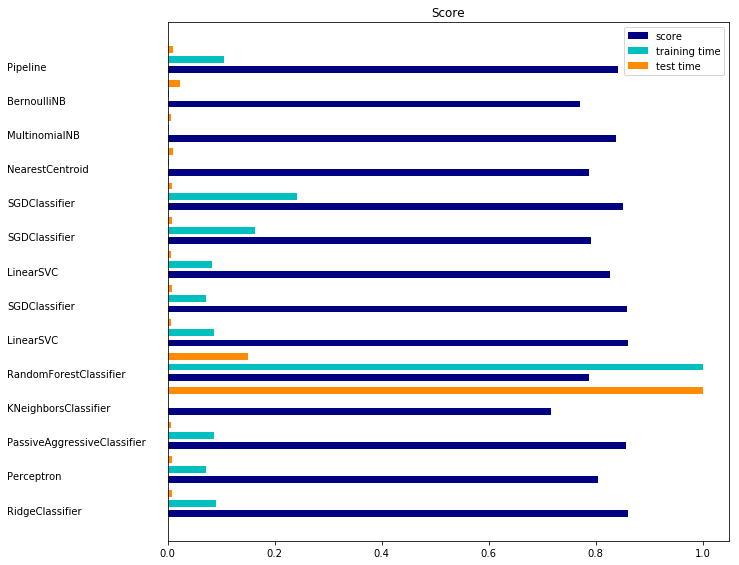

In [29]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(loss='l2', penalty=penalty,
                                            dual=False, tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', LinearSVC(penalty="l1", dual=False, tol=1e-3)),
  ('classification', LinearSVC())
])))

# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

In [26]:
for x in data_train.target:
    print(x)

1
3
2
0
2
0
2
1
2
1
2
1
1
2
1
2
0
2
2
3
2
1
3
3
1
1
2
1
2
3
0
3
1
1
0
2
0
1
0
2
0
2
0
1
1
0
0
3
3
3
1
2
3
2
1
0
1
1
1
1
2
0
1
1
2
1
2
0
1
3
1
2
2
1
2
1
0
0
2
1
3
3
0
3
2
2
0
2
0
3
1
3
0
2
0
3
0
3
2
2
0
0
3
2
3
2
2
1
0
2
3
3
2
2
2
2
3
1
3
0
0
3
1
2
2
0
2
3
0
2
1
2
2
3
1
1
3
0
2
2
3
1
0
2
2
0
0
1
2
0
0
1
1
1
3
3
3
3
3
1
2
2
2
1
2
2
1
3
2
0
3
3
2
1
1
0
0
3
2
2
3
3
0
2
1
1
2
1
1
0
0
1
0
1
3
1
0
0
3
2
3
3
0
2
3
1
1
1
0
2
0
2
0
0
1
1
3
2
0
0
1
0
2
2
2
0
1
3
2
0
1
0
1
0
2
3
2
2
1
1
1
3
0
0
3
0
3
1
3
2
2
3
3
3
1
2
3
0
2
1
3
0
2
1
3
1
0
2
1
2
2
3
0
3
3
2
3
1
0
0
2
1
0
1
3
2
2
0
2
2
1
1
3
2
0
2
0
1
3
2
3
1
3
2
2
1
0
0
1
2
0
3
1
3
2
0
0
2
1
3
3
2
0
1
0
3
3
0
2
2
2
0
0
1
0
3
1
1
1
2
3
1
1
2
1
1
0
3
3
2
0
1
1
2
2
1
1
2
1
3
1
1
0
1
0
1
1
0
0
1
0
1
0
2
2
1
2
0
1
0
0
1
2
1
1
3
0
1
2
2
1
3
0
1
2
0
2
1
0
0
1
3
2
1
1
2
1
1
2
0
0
0
0
2
2
3
2
2
2
0
2
2
0
1
0
2
1
0
1
1
1
3
1
1
3
3
3
2
2
1
0
2
2
0
2
1
3
1
0
2
2
1
3
0
2
0
1
2
3
1
1
2
0
3
1
1
3
0
1
0
1
1
2
3
3
1
1
0
0
2
1
2
1
2
1
2
2
2
2
2
3
3
1
0
1
1
1
2
2
1
